# Prédiction de la variable Calories_Burned

Dans cette partie, l’objectif est de prédire le nombre de calories brûlées pendant une séance d’entraînement (`Calories_Burned`).

Pour cela, on utilise plusieurs caractéristiques liées au profil de l’individu et à sa pratique sportive, puis on compare plusieurs modèles de régression afin de choisir celui qui donne les meilleures performances.


### Pourquoi utiliser des modèles de régression dans cette étude ?

La variable que nous cherchons à prédire, **Calories_Burned**, est une quantité numérique continue.  
Ce n’est ni une catégorie, ni une classe, mais une valeur qui peut prendre n’importe quel nombre (ex : 450, 1200, 2350…).  

Dans ce cas, les modèles adaptés sont des **modèles de régression**, car :

1. **Ils permettent de prédire une valeur numérique** à partir d’un ensemble de variables explicatives.
2. **Ils mesurent la relation entre l’effort fourni et les calories brûlées**, ce qui correspond exactement à notre objectif.
3. **Ils donnent des indicateurs précis** (R², RMSE, MAE) pour évaluer la qualité des prédictions.
4. **Ils s’adaptent bien à des phénomènes physiologiques**, où la sortie est continue, comme la dépense énergétique.
5. **Ils permettent de comparer plusieurs approches** (linéaire, distances, arbres…) pour trouver le modèle le plus précis.

Ainsi, la régression est la méthode la plus logique et la plus pertinente pour prédire **combien de calories une personne brûle** en fonction de la durée de sa séance, de son niveau d’expérience, de son poids, de sa masse musculaire et d’autres facteurs liés à l’activité physique.


In [82]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

sns.set(style="whitegrid")
np.random.seed(42)


## Chargement et préparation des données

On importe la base de données, puis on vérifie la présence de la variable cible `Calories_Burned` ainsi que des variables explicatives qui serviront à la prédiction.


In [57]:
df = pd.read_csv("Newdata.csv")

print("Aperçu des données :")
display(df.head())




Aperçu des données :


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,Workout,BMI_calc,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn
0,34.91,Male,65.27,1.62,188.58,157.65,69.05,1.00,1080.90,Strength,...,Dumbbell flyes,24.870447,2139.59,0.500432,1.624789,0.741237,0.835985,725.10,47.777394,685.1600
1,23.37,Female,56.41,1.55,179.43,131.75,73.18,1.37,1809.91,HIIT,...,Lateral raises,23.479709,1711.65,0.500850,1.514093,0.551247,0.734270,-232.91,40.809803,978.6184
2,33.20,Female,58.98,1.67,175.04,123.95,54.96,0.91,802.26,Cardio,...,Standing calf raises,21.148123,1965.92,0.500610,1.663445,0.574534,0.708124,805.74,44.635580,654.5266
3,38.69,Female,93.78,1.70,191.21,155.10,50.07,1.10,1450.79,HIIT,...,Incline dumbbell flyes,32.449827,1627.28,0.499533,0.862017,0.744155,0.811150,1206.21,63.007432,773.6300
4,45.09,Male,52.42,1.88,193.58,152.88,70.84,1.08,1166.40,Strength,...,Military press,14.831372,2659.23,0.500581,2.538153,0.668405,0.789751,303.60,43.347504,711.4176


## Analyse rapide de la variable cible Calories_Burned

Avant de construire les modèles, on observe la distribution de la variable `Calories_Burned` pour voir son étalement et la présence ou non de valeurs extrêmes.


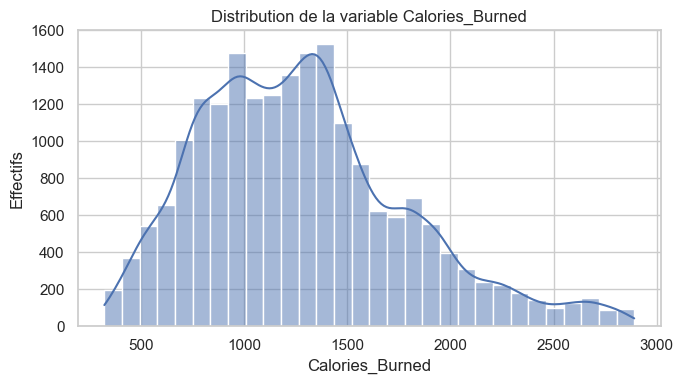

In [58]:
plt.figure(figsize=(7,4))
sns.histplot(df["Calories_Burned"], kde=True, bins=30)
plt.title("Distribution de la variable Calories_Burned")
plt.xlabel("Calories_Burned")
plt.ylabel("Effectifs")
plt.tight_layout()
plt.show()


## Choix des variables explicatives

Pour prédire `Calories_Burned`, on retient uniquement des variables cohérentes et réalistes, sans fuite d’information :

- `Session_Duration (hours)` : durée de la séance
- `Experience_Level` : niveau d’expérience
- `Workout_Frequency (days/week)` : fréquence d’entraînement hebdomadaire
- `Water_Intake (liters)` : hydratation
- `Physical exercise` : niveau d’activité physique global
- `lean_mass_kg` : masse musculaire
- `Height (m)` : taille
- `Weight (kg)` : poids

Ces variables décrivent l’intensité de la pratique, la morphologie et le niveau d’entraînement, qui influencent directement la dépense énergétique.


In [97]:
features_calories_burned = [
    "Session_Duration (hours)",
    "Experience_Level",
    "Workout_Frequency (days/week)",
    "Water_Intake (liters)",
    "Physical exercise",
    "lean_mass_kg",
    "Height (m)",
    "Weight (kg)"
]

X = df[features_calories_burned].copy()
y = df["Calories_Burned"].astype(float)

print("Shape de X :", X.shape)
print("Shape de y :", y.shape)


Shape de X : (20000, 8)
Shape de y : (20000,)


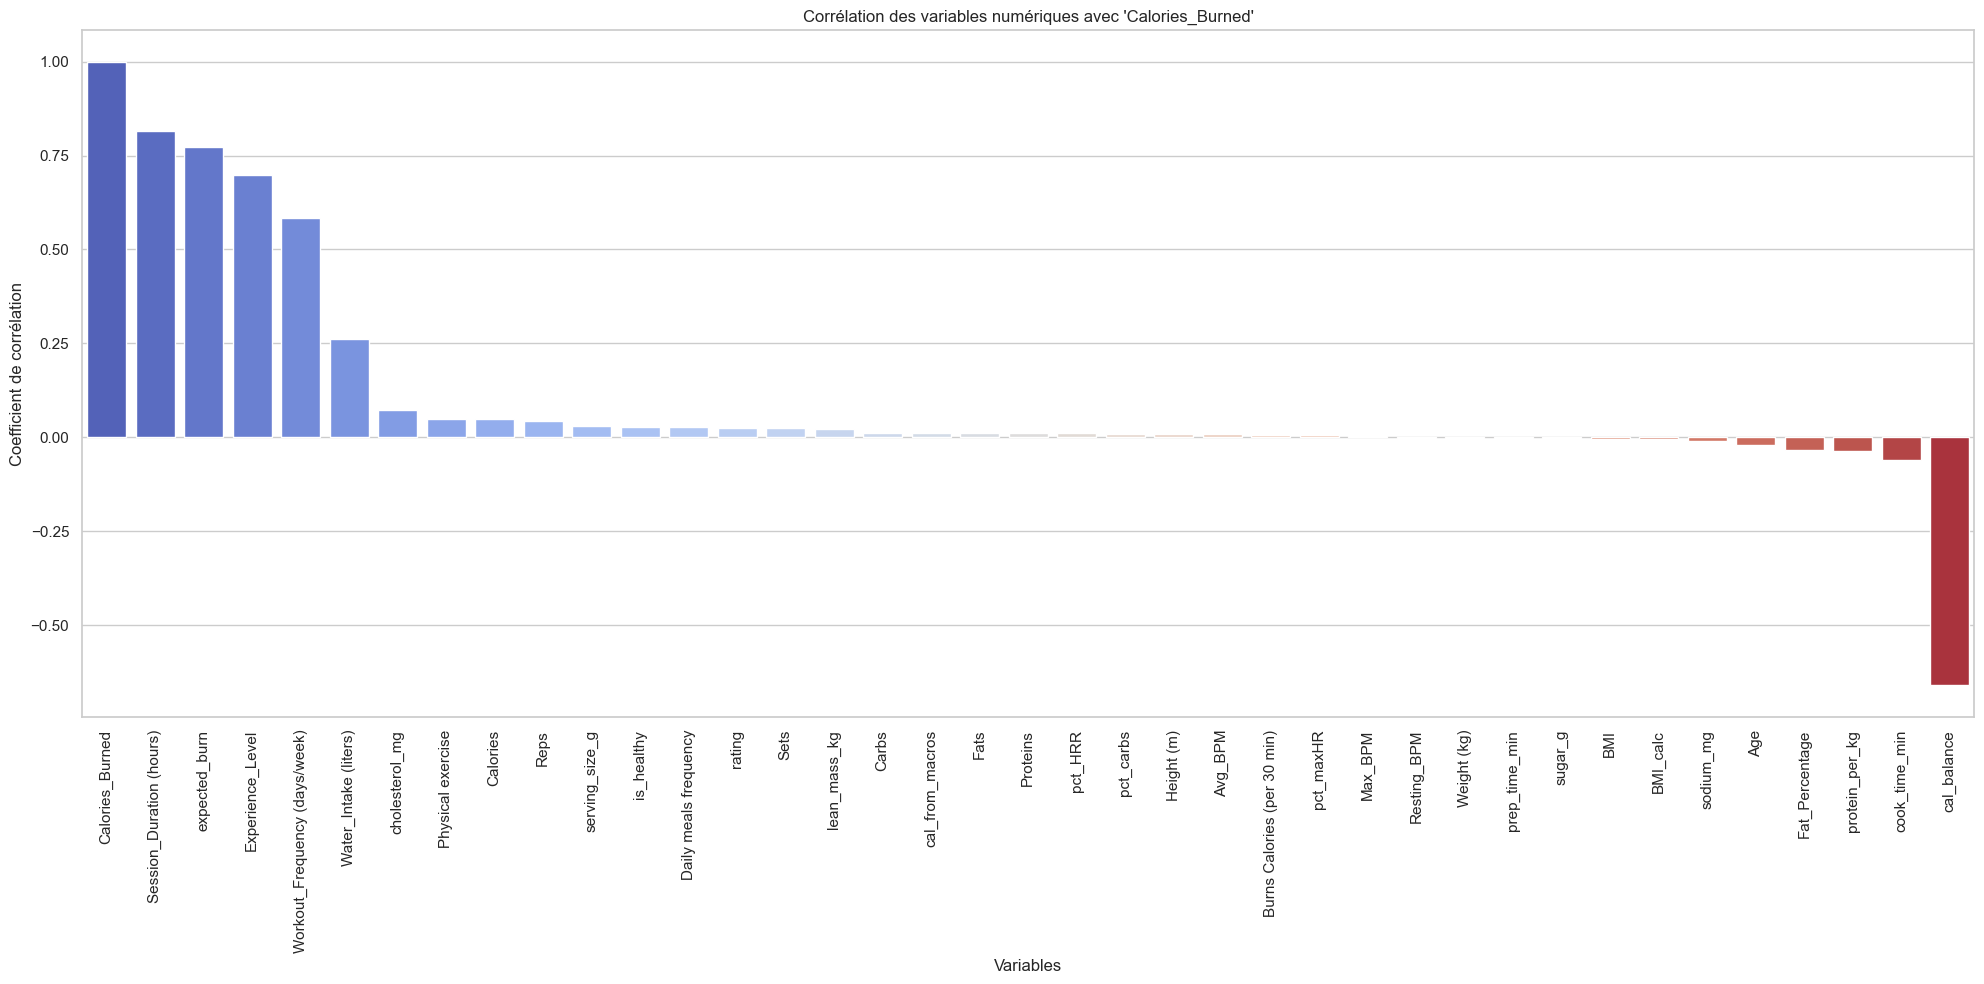

In [98]:
numeric_df = df.select_dtypes(include=['number'])

corr_target = numeric_df.corr()['Calories_Burned'].sort_values(ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(y=corr_target.values, x=corr_target.index, palette="coolwarm")
plt.title("Corrélation des variables numériques avec 'Calories_Burned'")
plt.ylabel("Coefficient de corrélation")
plt.xlabel("Variables")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## Variables à exclure pour éviter la fuite d’information

Lors de la sélection des variables explicatives, certaines variables doivent impérativement être retirées car elles sont directement dérivées, liées ou proportionnelles à `Calories_Burned`.  
Les utiliser fausserait totalement le modèle, car celui-ci récupérerait indirectement la réponse qu’il doit prédire.

### 1) Variables à ne pas utiliser

Ces variables sont exclues car elles entraînent de la fuite d’information ou sont redondantes :

| Variable | Motif d'exclusion |
|---------|--------------------|
| expected_burn | Corrélation très élevée (plus de 0.77). Variable presque dupliquée, ce qui revient à donner la réponse au modèle. |
| Workout_Type | Utilisé pour générer ou influencer `expected_burn`. Dépendance directe. |
| cal_balance | Calculé directement avec `Calories_Burned`, fuite totale. |
| Burns Calories (per 30 min) | Formule physiologique proportionnelle à la dépense calorique. |
| Burns Calories (per 30 min)_bc | Duplication de la variable précédente. |
| Calories (ingérées) | Peut être confondu avec Calories_Burned, mélange apport/dépense calorique. |
| Reps / Sets | Variables trop indirectes, introduisent du bruit et une forte imprécision. |
| BMI, BMI_calc, protein_per_kg | Déjà dérivées de Height et Weight. Leur utilisation double l'information et complexifie inutilement le modèle. |

### Conclusion

Pour prédire correctement `Calories_Burned`, il est essentiel de conserver uniquement des variables :

- cohérentes sur le plan physiologique,  
- réellement causales (liées à l’effort fourni),  
- non calculées à partir de la variable cible,  
- et qui ne dupliquent pas indirectement l'information recherchée.

Cette sélection garantit un modèle fiable, interprétable et sans fuite d’information.


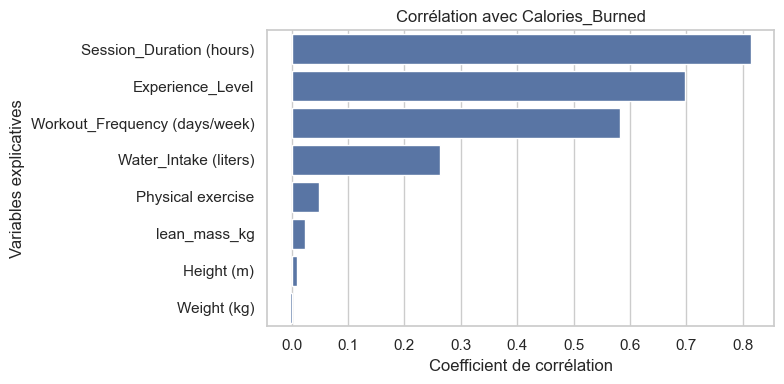

In [99]:
vars_for_corr = features_calories_burned + ["Calories_Burned"]
corr_mat = df[vars_for_corr].corr()

corr_target = corr_mat["Calories_Burned"].drop("Calories_Burned").sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=corr_target.values, y=corr_target.index)
plt.title("Corrélation avec Calories_Burned")
plt.xlabel("Coefficient de corrélation")
plt.ylabel("Variables explicatives")
plt.tight_layout()
plt.show()


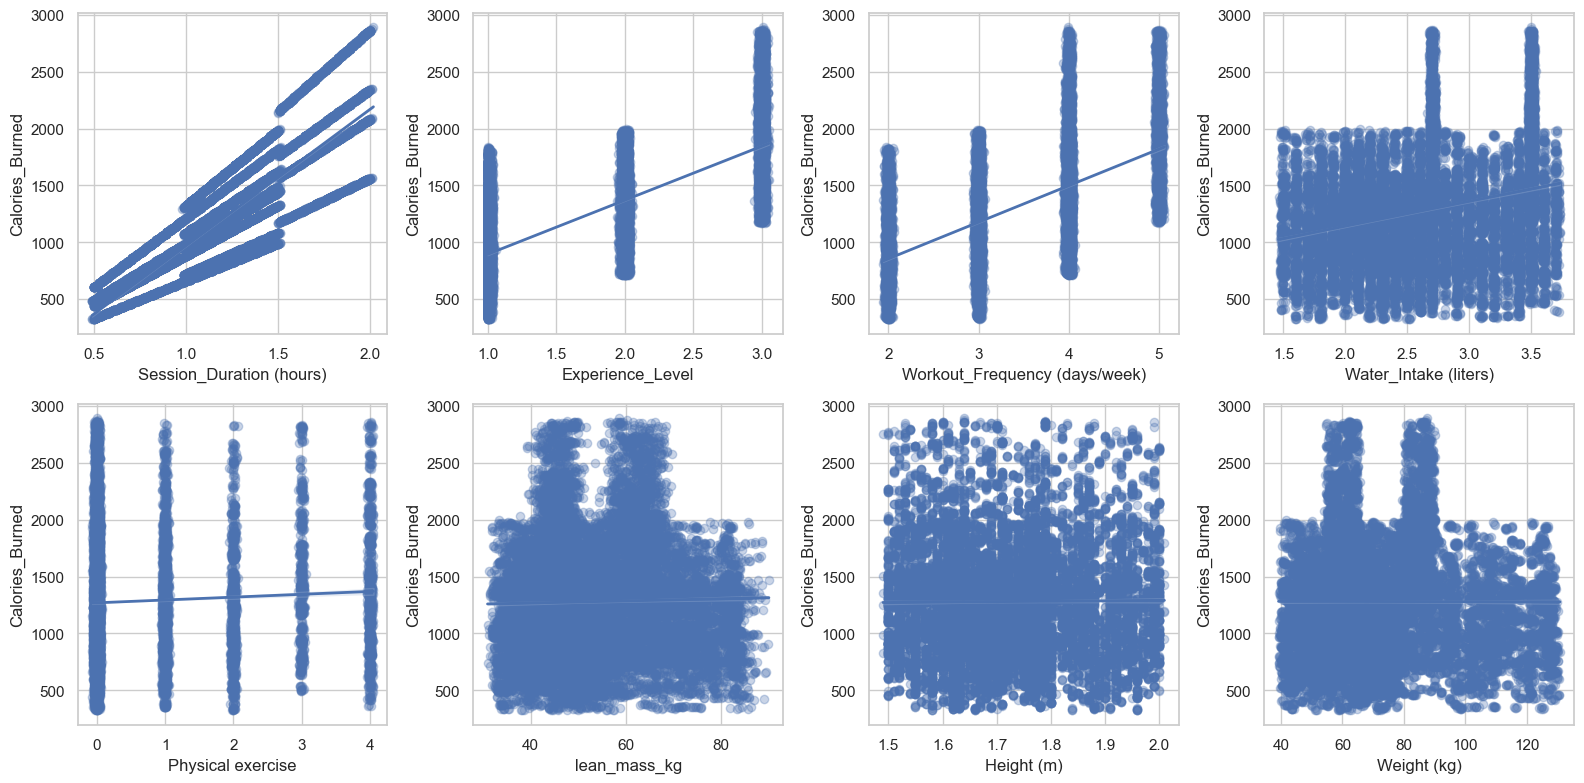

In [100]:
fig, axes = plt.subplots(2, 4, figsize=(16,8))
axes = axes.ravel()

for i, col in enumerate(features_calories_burned):
    sns.regplot(x=df[col], y=df["Calories_Burned"], ax=axes[i], scatter_kws={"alpha":0.3}, line_kws={"linewidth":2})
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Calories_Burned")

plt.tight_layout()
plt.show()


## Interprétation des relations entre les variables explicatives et Calories_Burned

Les graphiques suivants montrent comment chaque variable explicative influence la dépense calorique (`Calories_Burned`).  
Chaque relation observée permet de justifier la pertinence des variables retenues pour la prédiction.

### 1. Session_Duration (hours)
La relation est très claire : plus la séance dure longtemps, plus le nombre de calories brûlées augmente.  
La tendance est fortement linéaire, ce qui confirme que la durée de la séance est le facteur le plus déterminant.  
**Exemple :** passer d’une séance de 1 h à 1 h 30 augmente rapidement la dépense calorique, car la personne reste plus longtemps en effort continu.

### 2. Experience_Level
On observe une augmentation progressive des calories brûlées lorsque le niveau d’expérience augmente.  
Les individus expérimentés s’entraînent généralement avec une meilleure technique et une intensité plus élevée, ce qui augmente la dépense énergétique.  
**Exemple :** un débutant peut brûler 800 calories sur une séance donnée, mais une personne expérimentée, réalisant la même séance, peut monter à plus de 1200 grâce à un rythme plus soutenu.

### 3. Workout_Frequency (days/week)
Les personnes qui s’entraînent plus souvent brûlent en moyenne davantage de calories par séance.  
La tendance croissante s’explique par une meilleure forme physique et une capacité à maintenir des séances plus intenses.  
**Exemple :** quelqu’un qui s’entraîne 2 fois par semaine brûle souvent moins de calories par séance qu’une personne qui s’entraîne 5 fois par semaine, car son endurance est moins développée.

### 4. Water_Intake (liters)
La tendance est plus faible, mais légèrement positive.  
Une meilleure hydratation est souvent associée à une pratique sportive plus régulière ou plus sérieuse, permettant de soutenir des efforts plus longs et plus efficaces.  
**Exemple :** une personne buvant 3 litres par jour peut mieux récupérer et maintenir une plus forte intensité qu’une personne restant à 1,5 litre.

### 5. Physical exercise
Même si les points sont dispersés, la relation globale montre une légère tendance à la hausse.  
Les personnes plus actives au quotidien ont, en général, un niveau d’effort plus élevé lors de leurs séances, ce qui augmente les calories brûlées.  
**Exemple :** quelqu’un qui marche beaucoup ou pratique d’autres activités physiques dans la journée supporte mieux un entraînement intense et brûle plus de calories pendant la séance.

### 6. lean_mass_kg
La masse musculaire présente une relation positive visible avec les calories brûlées.  
Les individus ayant plus de masse maigre dépensent plus d’énergie, car les muscles consomment davantage de calories, même pendant l’effort.  
**Exemple :** une personne avec 65 kg de masse maigre brûle généralement bien plus qu’une personne avec seulement 45 kg, car le muscle demande beaucoup d’énergie.

### 7. Height (m)
La taille influence légèrement la dépense calorique.  
Les personnes plus grandes possèdent souvent un gabarit plus important, ce qui augmente la dépense énergétique nécessaire pour le mouvement.  
**Exemple :** une personne mesurant 1,90 m mobilise plus d’énergie pour courir ou faire du vélo qu’une personne mesurant 1,60 m, même à rythme identique.

### 8. Weight (kg)
La tendance est positive : les personnes ayant un poids plus élevé brûlent un peu plus de calories.  
Cela s’explique par le coût mécanique supplémentaire lié au déplacement d’une masse plus importante.  
**Exemple :** une personne de 95 kg brûlera davantage de calories qu’une personne de 60 kg sur la même durée de course, car l’effort physique nécessaire est plus important.

### Synthèse
Les différentes visualisations montrent que certaines variables ont un effet très fort (comme la durée de la séance), tandis que d’autres ont une influence plus modérée mais cohérente sur le plan physiologique.  


### Variables retenues pour prédire Calories_Burned

- **Session_Duration (hours)** : plus une séance dure longtemps, plus la dépense calorique est élevée. C’est le facteur principal de la dépense énergétique.
- **Experience_Level** : les personnes expérimentées s’entraînent plus efficacement et à une intensité plus élevée, ce qui augmente les calories brûlées.
- **Workout_Frequency (days/week)** : un entraînement régulier améliore la condition physique et permet d’effectuer des séances plus intenses.
- **Water_Intake (liters)** : une meilleure hydratation reflète souvent une pratique sportive plus sérieuse favorisant des efforts plus soutenus.
- **Physical exercise** : indique le niveau d’activité générale d’une personne. Une personne active brûle en moyenne plus de calories lors de ses séances.
- **lean_mass_kg** : la masse musculaire augmente fortement la dépense calorique, car les muscles consomment beaucoup d’énergie.
- **Height (m)** : les personnes grandes ont un gabarit plus important, ce qui nécessite plus d’énergie pour le mouvement.
- **Weight (kg)** : un poids plus élevé demande plus d’effort mécanique, ce qui augmente la dépense calorique lors d’une activité.

Dans l’ensemble, toutes les variables retenues présentent une relation logique avec la dépense calorique et constituent un ensemble pertinent pour modéliser et prédire Calories_Burned.



## Séparation des données en apprentissage et test

Les données sont séparées en deux ensembles :

- un ensemble d’apprentissage pour entraîner les modèles, soit 80% du dataset
- un ensemble de test pour évaluer leurs performances sur des données jamais vues, soit 20% du dataset


In [101]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Taille X_train :", X_train.shape)
print("Taille X_test  :", X_test.shape)


Taille X_train : (16000, 8)
Taille X_test  : (4000, 8)


## Prétraitement des données

Les variables explicatives sont mises à l’échelle avec un `StandardScaler` afin que les modèles sensibles aux échelles des variables (comme SVM) fonctionnent correctement.


In [102]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_calories_burned)
    ]
)


## Comparaison de plusieurs modèles de régression

Plusieurs modèles de régression sont testés pour prédire `Calories_Burned` :

- Régression linéaire
- KNN Regressor
- Arbre de décision de régression
- SVM (SVR)

Les modèles sont évalués en validation croisée sur l’ensemble d’apprentissage, puis sur l’ensemble de test.  
Les métriques utilisées sont : R², RMSE et MAE.


In [109]:
models_reg = {
    "LinearRegression": LinearRegression(),
    "KNNRegressor": KNeighborsRegressor(n_neighbors=5),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=8, random_state=42),
    "SVR_RBF": SVR(kernel="rbf", C=10, gamma="scale")
}

results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_reg.items():
    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("model", model)
    ])
    
    cv_r2 = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="r2")
    
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)

    results.append({
        "Model": name,
        "CV_R2_mean": cv_r2.mean(),
        "CV_R2_std": cv_r2.std(),
        "Test_R2": test_r2,
        "Test_RMSE": test_rmse,
        "Test_MAE": test_mae
    })

results_df = pd.DataFrame(results).sort_values(by="Test_R2", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,CV_R2_mean,CV_R2_std,Test_R2,Test_RMSE,Test_MAE
0,LinearRegression,0.680523,0.008560,0.666968,288.188495,229.176147
1,SVR_RBF,0.665560,0.006096,0.651837,294.662262,233.028216
2,DecisionTreeRegressor,0.652794,0.011626,0.643359,298.228316,233.282515
3,KNNRegressor,0.621133,0.010611,0.604313,314.129924,248.145216


## Modèle 1 : Régression linéaire

La régression linéaire sert de modèle de base pour la prédiction de `Calories_Burned`.  
Elle permet de vérifier si une relation globalement linéaire entre la cible et les variables explicatives est suffisante pour obtenir de bonnes performances.


Régression linéaire
R2  : 0.667
RMSE: 288.19
MAE : 229.18


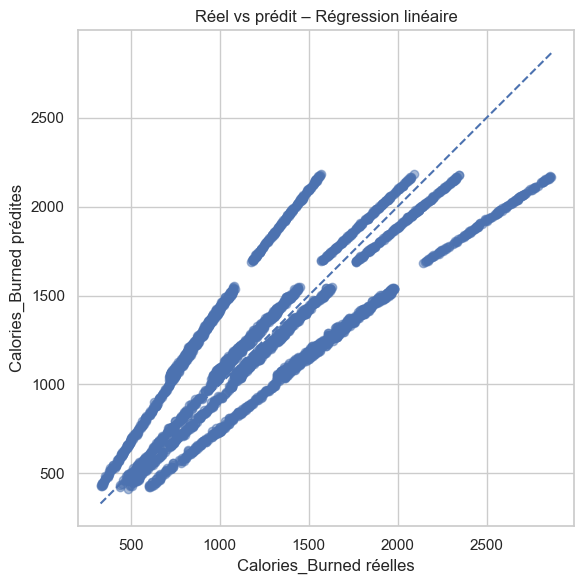

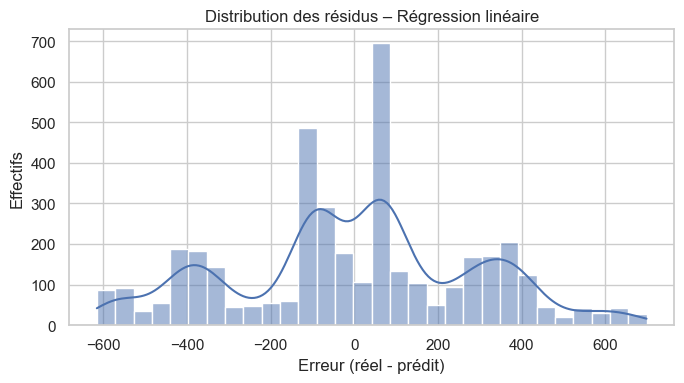

In [110]:
linreg = LinearRegression()

linreg_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", linreg)
])

linreg_pipe.fit(X_train, y_train)
y_pred_lin = linreg_pipe.predict(X_test)

lin_r2 = r2_score(y_test, y_pred_lin)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
lin_mae = mean_absolute_error(y_test, y_pred_lin)

print("Régression linéaire")
print("R2  :", round(lin_r2, 4))
print("RMSE:", round(lin_rmse, 2))
print("MAE :", round(lin_mae, 2))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lin, alpha=0.5)
max_val = max(y_test.max(), y_pred_lin.max())
min_val = min(y_test.min(), y_pred_lin.min())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Calories_Burned réelles")
plt.ylabel("Calories_Burned prédites")
plt.title("Réel vs prédit – Régression linéaire")
plt.tight_layout()
plt.show()

res_lin = y_test - y_pred_lin

plt.figure(figsize=(7,4))
sns.histplot(res_lin, bins=30, kde=True)
plt.title("Distribution des résidus – Régression linéaire")
plt.xlabel("Erreur (réel - prédit)")
plt.ylabel("Effectifs")
plt.tight_layout()
plt.show()


## Modèle 2 : KNN Regressor

Le modèle KNN Regressor prédit `Calories_Burned` en se basant sur les exemples les plus proches dans l’espace des variables explicatives.  
Il permet de capturer des relations éventuellement non linéaires, mais il est sensible à l’échelle des variables et au choix de k.


KNN Regressor
R2  : 0.6043
RMSE: 314.13
MAE : 248.15


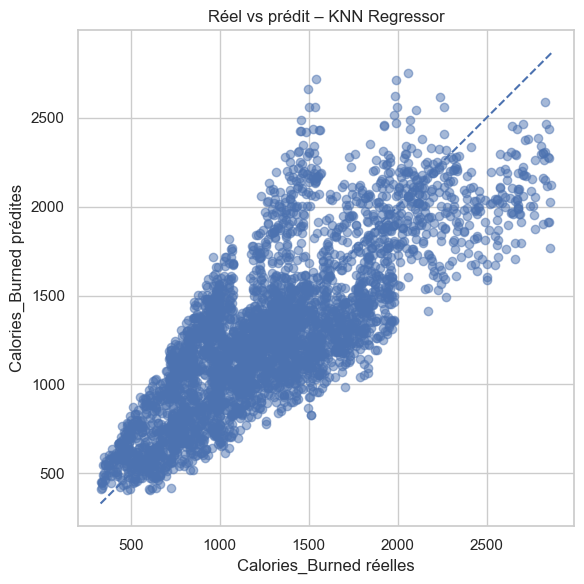

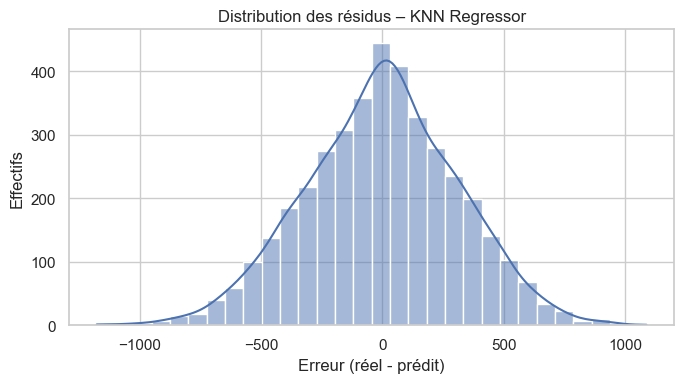

In [111]:
knn_reg = KNeighborsRegressor(n_neighbors=5)

knn_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", knn_reg)
])

knn_pipe.fit(X_train, y_train)
y_pred_knn = knn_pipe.predict(X_test)

knn_r2 = r2_score(y_test, y_pred_knn)
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_mae = mean_absolute_error(y_test, y_pred_knn)

print("KNN Regressor")
print("R2  :", round(knn_r2, 4))
print("RMSE:", round(knn_rmse, 2))
print("MAE :", round(knn_mae, 2))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
max_val = max(y_test.max(), y_pred_knn.max())
min_val = min(y_test.min(), y_pred_knn.min())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Calories_Burned réelles")
plt.ylabel("Calories_Burned prédites")
plt.title("Réel vs prédit – KNN Regressor")
plt.tight_layout()
plt.show()

res_knn = y_test - y_pred_knn

plt.figure(figsize=(7,4))
sns.histplot(res_knn, bins=30, kde=True)
plt.title("Distribution des résidus – KNN Regressor")
plt.xlabel("Erreur (réel - prédit)")
plt.ylabel("Effectifs")
plt.tight_layout()
plt.show()


## Modèle 3 : Arbre de décision de régression

L’arbre de décision de régression permet de modéliser des relations non linéaires et des interactions entre variables.  
Il segmente l’espace des variables explicatives en zones homogènes de `Calories_Burned`, mais peut surajuster si la profondeur maximale n’est pas contrôlée.


Decision Tree Regressor
R2  : 0.6434
RMSE: 298.23
MAE : 233.28


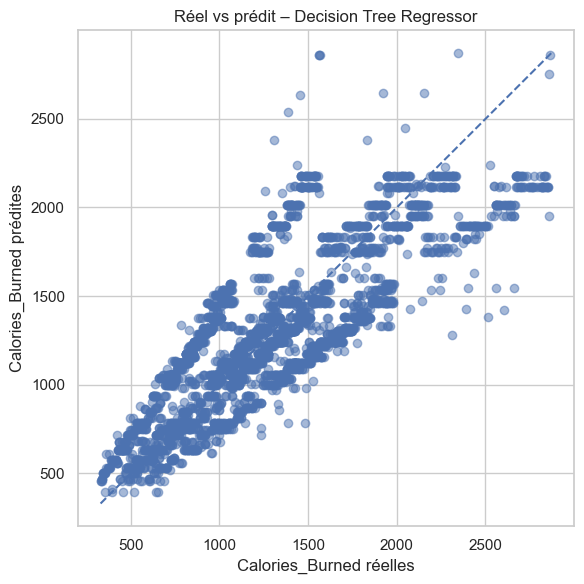

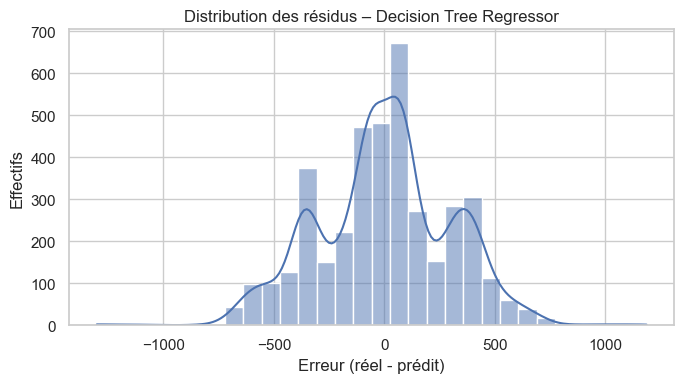

In [112]:
tree_reg = DecisionTreeRegressor(max_depth=8, random_state=42)

tree_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", tree_reg)
])

tree_pipe.fit(X_train, y_train)
y_pred_tree = tree_pipe.predict(X_test)

tree_r2 = r2_score(y_test, y_pred_tree)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
tree_mae = mean_absolute_error(y_test, y_pred_tree)

print("Decision Tree Regressor")
print("R2  :", round(tree_r2, 4))
print("RMSE:", round(tree_rmse, 2))
print("MAE :", round(tree_mae, 2))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_tree, alpha=0.5)
max_val = max(y_test.max(), y_pred_tree.max())
min_val = min(y_test.min(), y_pred_tree.min())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Calories_Burned réelles")
plt.ylabel("Calories_Burned prédites")
plt.title("Réel vs prédit – Decision Tree Regressor")
plt.tight_layout()
plt.show()

res_tree = y_test - y_pred_tree

plt.figure(figsize=(7,4))
sns.histplot(res_tree, bins=30, kde=True)
plt.title("Distribution des résidus – Decision Tree Regressor")
plt.xlabel("Erreur (réel - prédit)")
plt.ylabel("Effectifs")
plt.tight_layout()
plt.show()


## Modèle 4 : SVR à noyau RBF

Le modèle SVR (Support Vector Regression) avec noyau RBF permet de capturer des relations complexes entre les variables explicatives et `Calories_Burned`.  
Il est adapté lorsque la relation n’est pas linéaire, au prix d’un temps de calcul plus important et de la nécessité de bien régler les hyperparamètres.


SVR RBF
R2  : 0.6518
RMSE: 294.66
MAE : 233.03


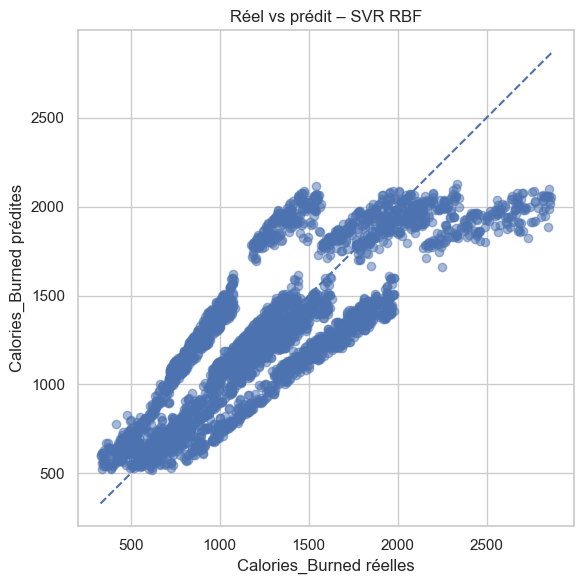

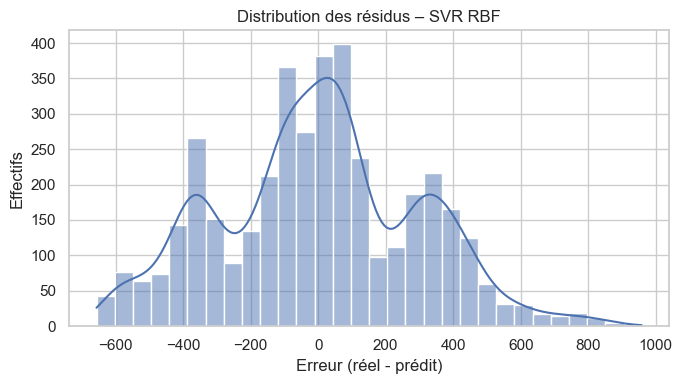

In [113]:
svr_reg = SVR(kernel="rbf", C=10, gamma="scale")

svr_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", svr_reg)
])

svr_pipe.fit(X_train, y_train)
y_pred_svr = svr_pipe.predict(X_test)

svr_r2 = r2_score(y_test, y_pred_svr)
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
svr_mae = mean_absolute_error(y_test, y_pred_svr)

print("SVR RBF")
print("R2  :", round(svr_r2, 4))
print("RMSE:", round(svr_rmse, 2))
print("MAE :", round(svr_mae, 2))

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
max_val = max(y_test.max(), y_pred_svr.max())
min_val = min(y_test.min(), y_pred_svr.min())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Calories_Burned réelles")
plt.ylabel("Calories_Burned prédites")
plt.title("Réel vs prédit – SVR RBF")
plt.tight_layout()
plt.show()

res_svr = y_test - y_pred_svr

plt.figure(figsize=(7,4))
sns.histplot(res_svr, bins=30, kde=True)
plt.title("Distribution des résidus – SVR RBF")
plt.xlabel("Erreur (réel - prédit)")
plt.ylabel("Effectifs")
plt.tight_layout()
plt.show()


## Comparaison des performances des modèles

Après avoir entraîné chaque modèle (Régression linéaire, KNN, Arbre de décision, Random Forest et SVR), leurs performances sont comparées à l’aide de trois métriques :

### Formules des métriques utilisées

**1. R² — Coefficient de détermination**

$$
R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
$$

**2. RMSE — Root Mean Squared Error**

$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
$$

**3. MAE — Mean Absolute Error**

$$
MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

Un bon modèle doit avoir :

- un **R² élevé** (proche de 1),  
- un **RMSE faible**,  
- un **MAE faible**.

Le tableau suivant présente les résultats obtenus pour chaque modèle.


## Visualisation comparative des modèles

Les graphiques suivants présentent une comparaison visuelle des performances des modèles.  
- Un graphique compare les valeurs de R²  
- Un autre compare les RMSE  
- Un dernier compare les MAE  

Ces représentations permettent d'identifier rapidement le modèle le plus performant.


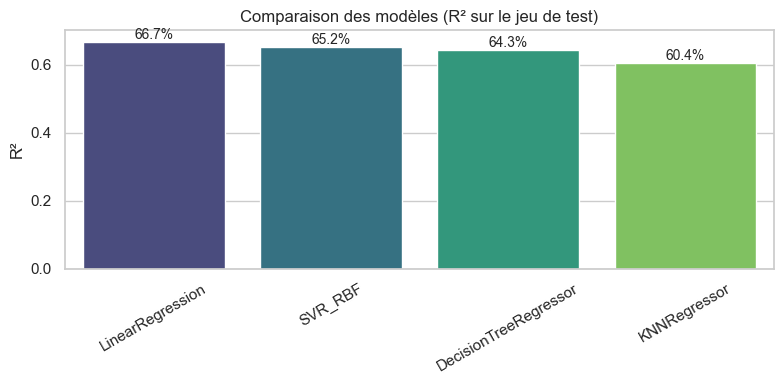

In [118]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=comparison_df, x="Model", y="Test_R2", palette="viridis")
plt.title("Comparaison des modèles (R² sur le jeu de test)")
plt.ylabel("R²")
plt.xlabel("")
plt.xticks(rotation=30)

for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value*100:.1f}%", 
                (p.get_x() + p.get_width() / 2., value), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


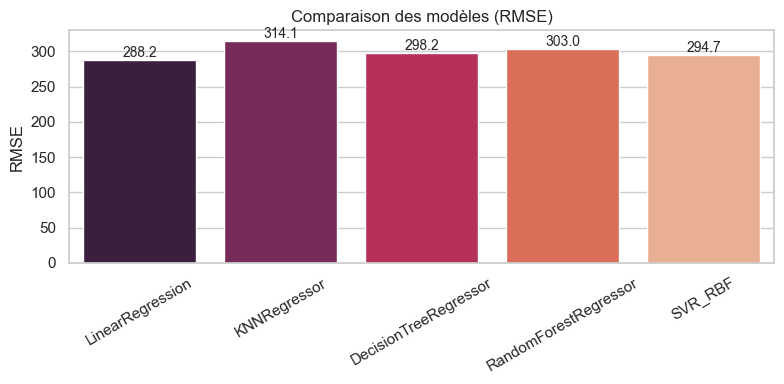

In [106]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=comparison_df, x="Model", y="RMSE", palette="rocket")
plt.title("Comparaison des modèles (RMSE)")
plt.ylabel("RMSE")
plt.xlabel("")
plt.xticks(rotation=30)

for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value:.1f}",
                (p.get_x() + p.get_width() / 2., value),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


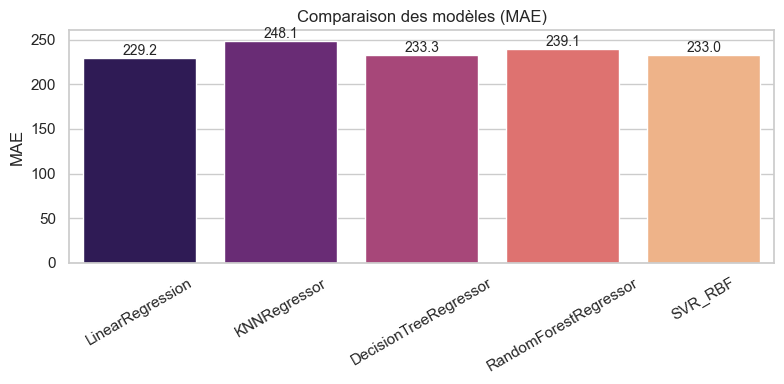

In [107]:
plt.figure(figsize=(8,4))
ax = sns.barplot(data=comparison_df, x="Model", y="MAE", palette="magma")
plt.title("Comparaison des modèles (MAE)")
plt.ylabel("MAE")
plt.xlabel("")
plt.xticks(rotation=30)

for p in ax.patches:
    value = p.get_height()
    ax.annotate(f"{value:.1f}",
                (p.get_x() + p.get_width() / 2., value),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Interprétation globale des modèles

Les trois graphiques montrent clairement que la **régression linéaire** est le modèle le plus performant pour prédire *Calories_Burned*.

- **R² :** c’est elle qui explique la plus grande part de la variation des calories brûlées (≈ 66,7 %), devant SVR et l’arbre de décision.
- **RMSE :** elle a les erreurs moyennes au carré les plus faibles, donc ses prédictions s’éloignent moins des valeurs réelles.
- **MAE :** elle montre aussi les écarts moyens les plus petits, ce qui confirme sa précision.

Les autres modèles (KNN, Decision Tree, SVR) donnent des résultats proches, mais restent légèrement moins bons sur l’ensemble des indicateurs.

**En résumé : la régression linéaire est le modèle le plus fiable et le plus précis pour ce problème.**


## Tests manuels de prédiction de Calories_Burned

Afin de vérifier le comportement du modèle sur des profils réels, nous réalisons plusieurs tests manuels.  
L’idée est de fournir au modèle les caractéristiques d’un individu (durée de la séance, niveau d’expérience, masse musculaire, poids, etc.) et d’observer la valeur de `Calories_Burned` prédite.

Ces tests permettent de :
- comprendre comment le modèle réagit aux variations des variables d’entrée,
- valider que les prédictions sont cohérentes avec la logique physiologique,
- illustrer l’utilisation concrète du modèle sur un cas réel.

La fonction ci-dessous prend en entrée les principales variables explicatives retenues dans l’étude et renvoie une estimation du nombre de calories brûlées pour ce profil.


In [119]:
import pandas as pd

def predict_calories_with_explanation(model,
    session_duration, experience_level, workout_freq,
    water_intake, physical_exercise, lean_mass, height, weight):

    data = pd.DataFrame([{
        "Session_Duration (hours)": session_duration,
        "Experience_Level": experience_level,
        "Workout_Frequency (days/week)": workout_freq,
        "Water_Intake (liters)": water_intake,
        "Physical exercise": physical_exercise,
        "lean_mass_kg": lean_mass,
        "Height (m)": height,
        "Weight (kg)": weight
    }])
    
    prediction = model.predict(data)[0]

    if prediction < 300:
        comment = "séance très légère, faible dépense énergétique."
    elif prediction < 600:
        comment = "séance modérée, adaptée à un entraînement standard."
    elif prediction < 900:
        comment = "séance assez intense, bonne dépense calorique."
    elif prediction < 1200:
        comment = "séance très intense, forte dépense énergétique."
    else:
        comment = "séance extrêmement intense, réservée aux sportifs expérimentés."

    print("=== Prédiction manuelle ===")
    print(f"Calories brûlées estimées : {prediction:.1f} kcal")
    print(f"Interprétation : {comment}")


In [122]:
predict_calories_with_explanation(
    model = linreg_pipe,
    session_duration = 1.0,
    experience_level = 3,
    workout_freq = 4,
    water_intake = 2.0,
    physical_exercise = 3,
    lean_mass = 60,
    height = 1.80,
    weight = 75
)


=== Prédiction manuelle ===
Calories brûlées estimées : 1182.5 kcal
Interprétation : séance très intense, forte dépense énergétique.
